# Predicción de series temporales con Keras `SimpleRNN`

En este notebook, mostramos la construcción de una simple red neuronal recurrente (RNN) usando Keras.

Generaremos algunos datos de series temporales sintéticas multiplicando dos señales periódicas/sinusoidales y añadiendo algo de estocasticidad (ruido gaussiano). A continuación, tomaremos una pequeña fracción de los datos y entrenaremos un modelo RNN simple con ellos e intentaremos predecir el resto de los datos y ver cómo coinciden las predicciones con la verdad.

## Sobre redes neuronales recurrentes (RNN)

Las RNN son RRNN especializadas en series temporales y en tratamiento de texto. Mediante sus capas ocultas son capaces de retener información sobre lo acontecido hasta el momento.

#### LSTM: Long Short Memory Layer. 
Son capas capaces de trabajar con secuencias de datos. Muy útiles para vídeo o speech recognition. Las neuronas tienen una memoria de los valores anteriores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

2024-07-23 15:53:36.592658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 15:53:36.662373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 15:53:36.693497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 15:53:36.703125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 15:53:36.752352: I tensorflow/core/platform/cpu_feature_guar

In [6]:
# Total time points
N = 3004

np.random.seed(0)
t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)

df = pd.DataFrame(x, columns=['Data'])
df.head()

,Data
0,0.882026
1,0.200199
2,0.489849
3,1.121526
4,0.935697


Esta tendencia no va a ser sencilla de conseguir. En general bien, pero hay algunas partes raras que no siguen la tendencia, debido al ruido gausiano.

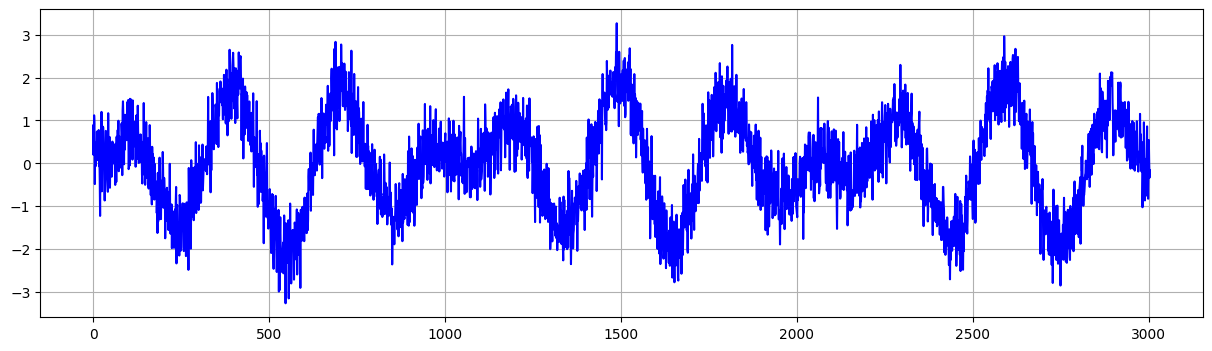

In [7]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True);

### Dividir los valores en entrenamiento y prueba

Así pues, tomamos sólo el 25% de los datos como muestras de entrenamiento y reservamos el resto de los datos para las pruebas. 

Observando el gráfico de la serie temporal, pensamos que **no es fácil que un modelo estándar consiga predicciones de tendencia correctas**.

In [8]:
values = df.values

# Time point to partition train/test splits.
# 25% of data (754) for TRAIN and the rest for test
Tp = 754   

train, test = values[0:Tp ,:], values[Tp:N,:]

In [9]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (754, 1)
Test data length: (2250, 1)


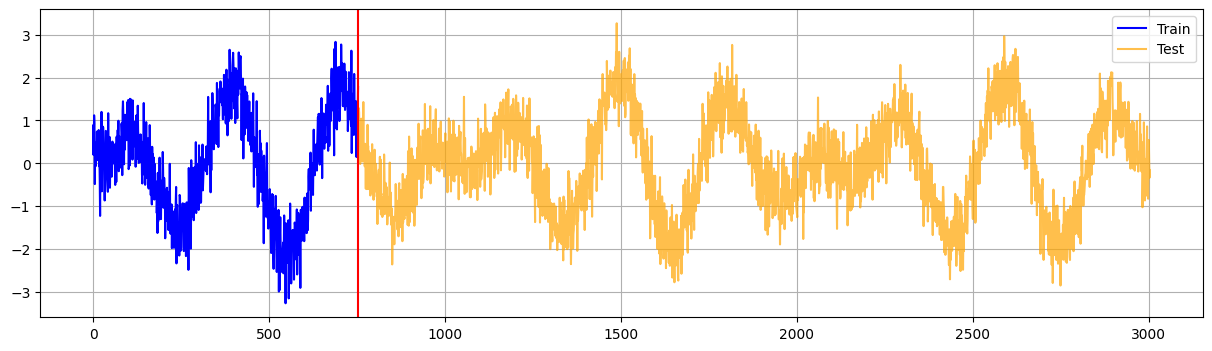

In [10]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(Tp, c="r")
plt.grid(True);

### Paso (o _embedding_)
El modelo RNN requiere un valor de paso que contenga $n $número de elementos como secuencia de entrada.

Supongamos x = {1,2,3,4,5,6,7,8,9,10}

para `paso=1`, la entrada $x$ y su predicción $y$ se convierten en:

| x | y |
|---|---|
| 1 | 2 |
| 2 | 3 |
| 3 | 4 |
| ...  | ...  |
| 9 | 10 |

para `paso=3`, $x$ e $y$ contienen:

| x | y |
|---|---|
| 1,2,3 | 4 |
| 2,3,4 | 5 |
| 3,4,5 | 6 |
| ...  | ...  |
| 7,8,9 | 10 |

Aquí, elegimos `paso=4`. En RNN más complejas y en particular para el procesamiento de texto, esto también se llama _embedding size_.

Básicamente los pasos son el número de lags necesarios para realizar las predicciones. Escogemos 4 lags.

Se los añade al final repetidos porque luego los eliminará al principio, ya que no puede hacer las predicciones de los lags 1,2,3

In [11]:
df2 = df.copy() # Por si las moscas
emb_size = 4 # Pasos

for i in range(1, emb_size+1):
    df2['lag' + str(i)] = df2['Data'].shift(i)

In [12]:
df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)
df2

,Data,lag1,lag2,lag3,lag4
0,0.935697,1.121526,0.489849,0.200199,0.882026
1,-0.485644,0.935697,1.121526,0.489849,0.200199
2,0.479354,-0.485644,0.935697,1.121526,0.489849
3,-0.069818,0.479354,-0.485644,0.935697,1.121526
4,-0.043963,-0.069818,0.479354,-0.485644,0.935697
...,...,...,...,...,...
2995,-0.277347,-0.828811,-0.303959,-0.646398,0.862306
2996,0.545401,-0.277347,-0.828811,-0.303959,-0.646398
2997,0.019247,0.545401,-0.277347,-0.828811,-0.303959
2998,-0.335919,0.019247,0.545401,-0.277347,-0.828811


In [14]:
values = df2.values

'''
Volvemos a montar xtrain, xtest...
'''
trainX,trainY = values[0:Tp-emb_size ,1:],values[0:Tp-emb_size ,0],
testX,testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (750, 4)
Train target length: (750,)
Test data length: (2250, 4)
Test target length: (2250,)


750 son los instantes para entrenar (eq a nº muestras).

1 x 4 dimensiones de estos dato, como una imagen. Si fuesen mas variables el 1 seria 2 o 3??

1 es una fila de datos, necesita ese formato

4 los lags para la capa LSTM

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(750, 1, 4)

In [16]:
trainX[:3]

array([[[ 1.12152594,  0.48984886,  0.2001986 ,  0.88202617]],

       [[ 0.9356969 ,  1.12152594,  0.48984886,  0.2001986 ]],

       [[-0.48564405,  0.9356969 ,  1.12152594,  0.48984886]]])

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(750, 1, 4)

- 750: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [17]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


### Modelo en Keras

- 256 neuronas en la capa RNN
- 32 en la capa densamente conectada
- Una simple neurona como salida.
- activation: ReLu
- learning rate: 0.001

In [20]:
from tensorflow.keras.layers import Dense, LSTM

def rnn_simple(num_units=128, embedding=4,num_dense=32, lr=0.001):
    """
    Construye un modelo sencillo usando capas LSTM

    Arguments:
              num_units: Número de unidades en la capa LSTM
              embedding: Tamaño del embedding (pasos)
              num_dense: Número de neuronas en la capa densa
              lr: Learning rate (RMSprop optimizer)
    Returns:
              Un modelo Keras (arquitectura LSTM -> Densa -> Densa(1))
    """
    model = Sequential()
    # Long short term memory
    # Esto es capa de entrada + capa con 128 neuronas con su función de activacion
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr), # adam
                  metrics=['mse'])
    
    return model

In [21]:
model = rnn_simple() # Taking the defaults

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,257 (282.25 KB)

 Trainable params: 72,257 (282.25 KB)

 Non-trainable params: 0 (0.00 B)

Callback para ofrecer feedback a las 50 iteraciones. Enseña mensaje si la epoch es múltiplo de 50 y no ha acabado de entrenar.
Cada vez que termina una epoch, Keras llama a on_epoch_end()

In [23]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Entrenamiento

In [24]:
batch_size=16
num_epochs = 1000

In [25]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

I0000 00:00:1721743368.871835   44427 service.cc:146] XLA service 0x78be1c001d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721743368.871855   44427 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-07-23 16:02:48.910734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 16:02:49.031904: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1721743369.778861   44427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [ ]:
# Guardamos el modelo
#model.save("my_model.h5")

### Graficamos la pérdida

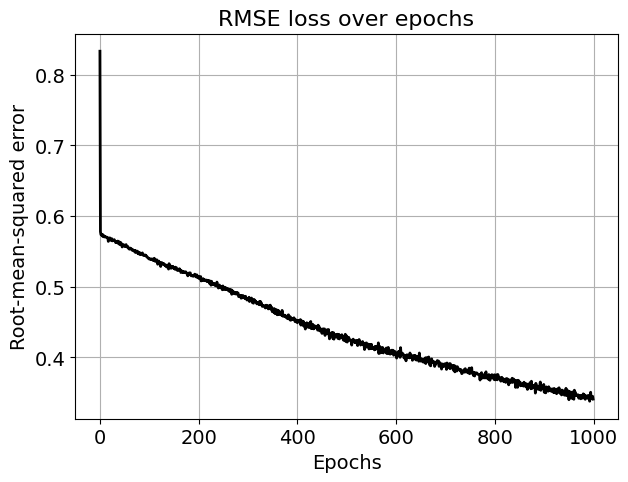

In [26]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Predicciones

Tened en cuenta que los datos fueron entrenados únicamente con `trainX` y `trainY`. 

In [27]:
trainX

array([[[ 1.12152594,  0.48984886,  0.2001986 ,  0.88202617]],

       [[ 0.9356969 ,  1.12152594,  0.48984886,  0.2001986 ]],

       [[-0.48564405,  0.9356969 ,  1.12152594,  0.48984886]],

       ...,

       [[ 1.3982905 ,  1.18968785,  0.15138804,  1.44883844]],

       [[ 0.15490176,  1.3982905 ,  1.18968785,  0.15138804]],

       [[ 1.18327014,  0.15490176,  1.3982905 ,  1.18968785]]])

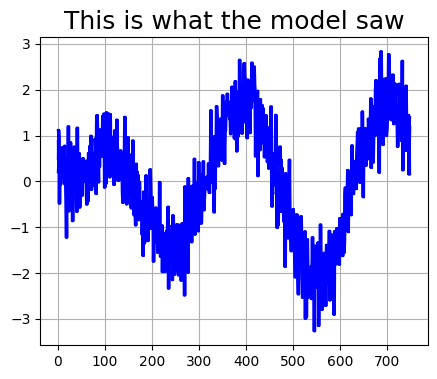

In [28]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
# Saca todos los valores de train, la primera columna
plt.plot(trainX[:,0],c='blue')
plt.grid(True)
plt.show()

In [29]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


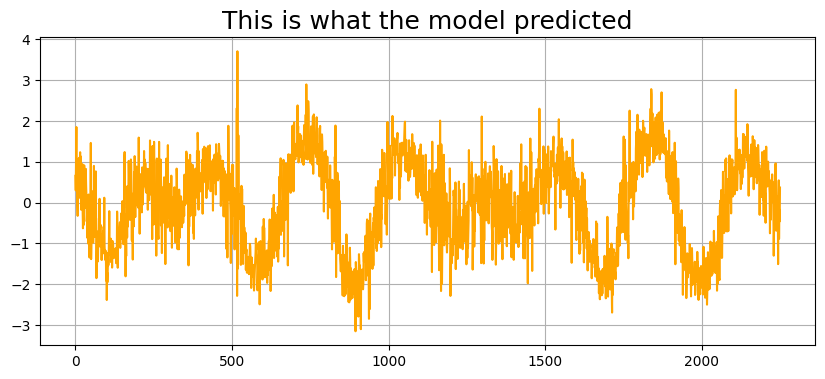

In [30]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

### Comparando con el ground-truth (la verdad observada)

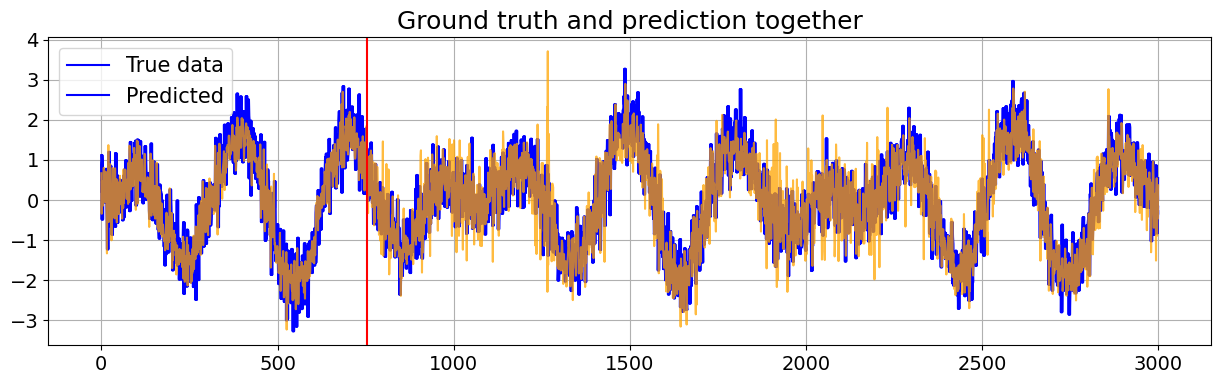

In [31]:
index = df2.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df2,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### ¿Cómo se distribuyen los errores?

Los errores, o residuos, como se denominan en un problema de regresión, pueden representarse gráficamente para ver si siguen alguna distribución específica. En el proceso de generación, inyectamos ruido gaussiano, por lo que esperamos que el error siga el mismo patrón, _si el modelo ha sido capaz de ajustarse a los datos reales correctamente_.

Si encontramos patrones raros en los residuos es porque el modelo no se ha ajustado
bien a los datos. Habría que probar otras configuraciones/modelos.

In [32]:
error = predicted[Tp:N]-df2[Tp:N]
# Ravel elimina una dimension, lo aplana todo. Como flatten
error = np.array(error).ravel()

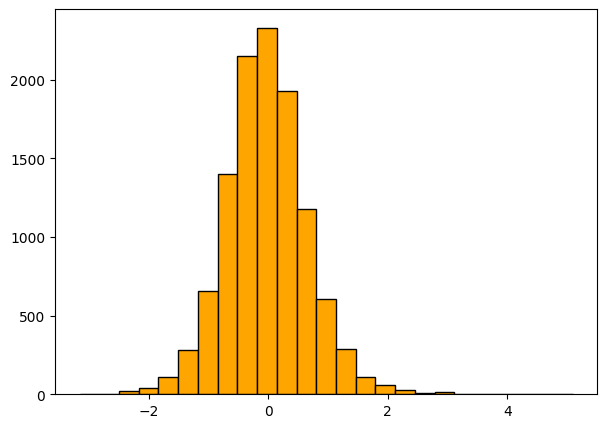

In [33]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

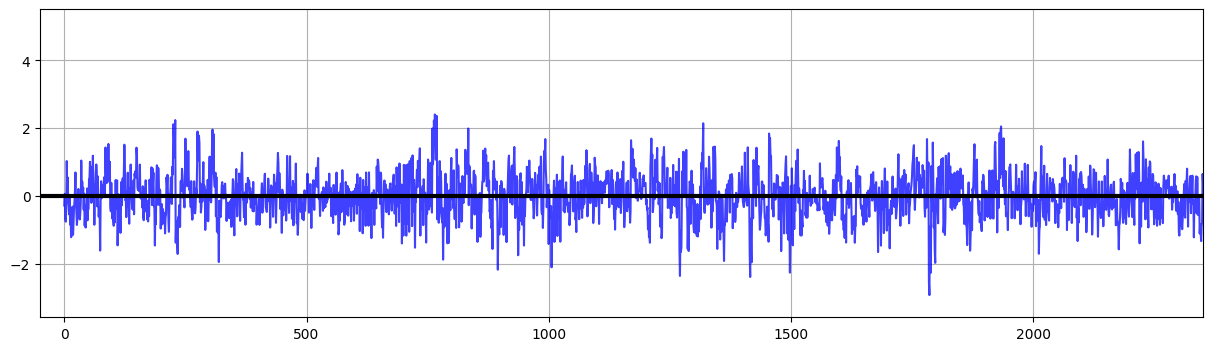

In [34]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True);

## Mejorando el modelo

Tened en cuenta que, para que estos experimentos sean razonablemente rápidos, fijaremos el tamaño del modelo para que sea más pequeño que el modelo anterior. Utilizaremos una capa RNN de 32 neuronas seguida de una capa densamente conectada de 8 neuronas.

### Variando el embedding/step size

In [35]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [36]:
def plot_compare(predicted, df2):
    index = df2.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df2,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df2.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [37]:
def prepare_data(step=4):
    df2 = df.copy()
    emb_size = step
    for i in range(1, emb_size+1):
        df2['lag' + str(i)] = df2['Data'].shift(i)

    df2.dropna(inplace=True)
    df2.reset_index(drop=True, inplace=True)

    values = df2.values

    trainX,trainY = values[0:Tp-emb_size ,1:],values[0:Tp-emb_size ,0],
    testX,testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY,df2

In [38]:
from sklearn.metrics import mean_absolute_error

def errors(testX, testY):
    y_true = testY
    y_pred = model.predict(testX)
    return mean_absolute_error(y_true=y_true, y_pred=y_pred)

Parece que cuanto mayor es la ventana, peor le está viniendo al modelo más ruido le mete. También es cierto, para 100 epochs

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Embedding size: 2
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
MAE: 0.4660458999749371
----------------------------------------------------------------------------------------------------


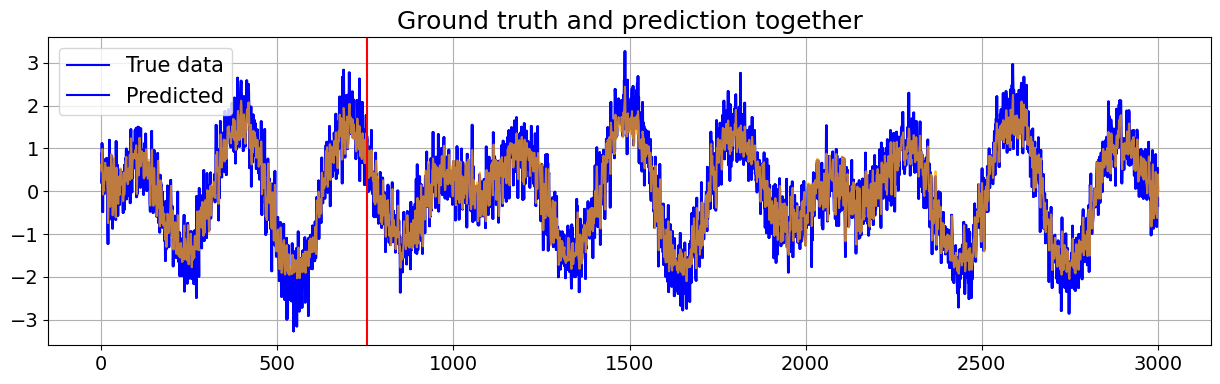

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Embedding size: 4
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
MAE: 0.4329874775063639
----------------------------------------------------------------------------------------------------


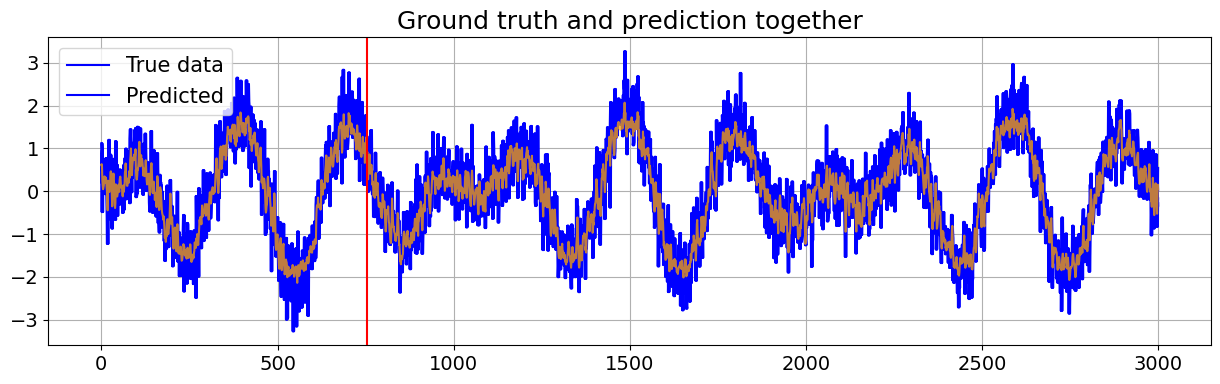

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Embedding size: 6
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
MAE: 0.4229347385328692
----------------------------------------------------------------------------------------------------


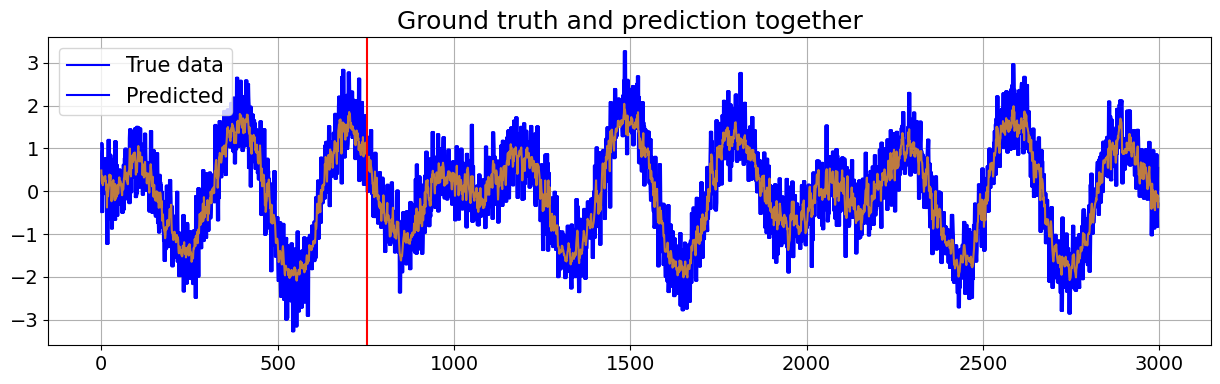

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
Embedding size: 8
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
MAE: 0.4326766603235265
----------------------------------------------------------------------------------------------------


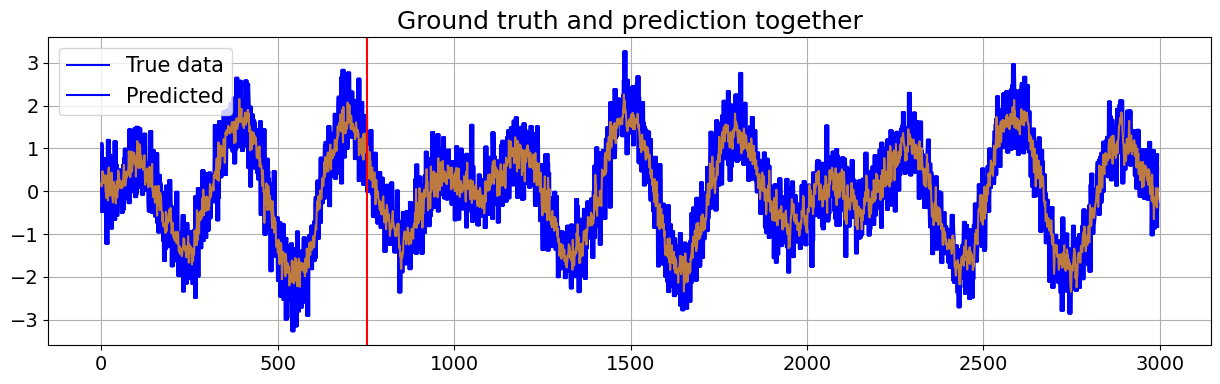

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Embedding size: 10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
MAE: 0.43600857382305813
----------------------------------------------------------------------------------------------------


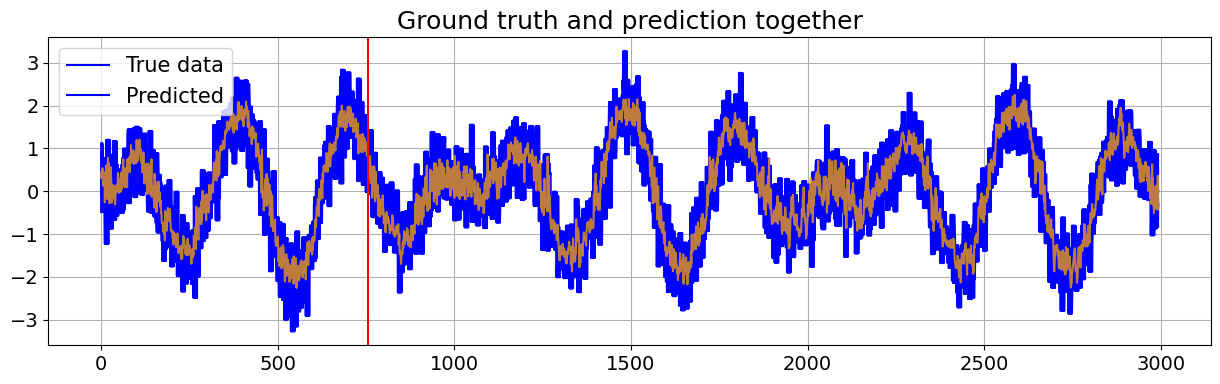

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Embedding size: 12
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
MAE: 0.4523684770535244
----------------------------------------------------------------------------------------------------


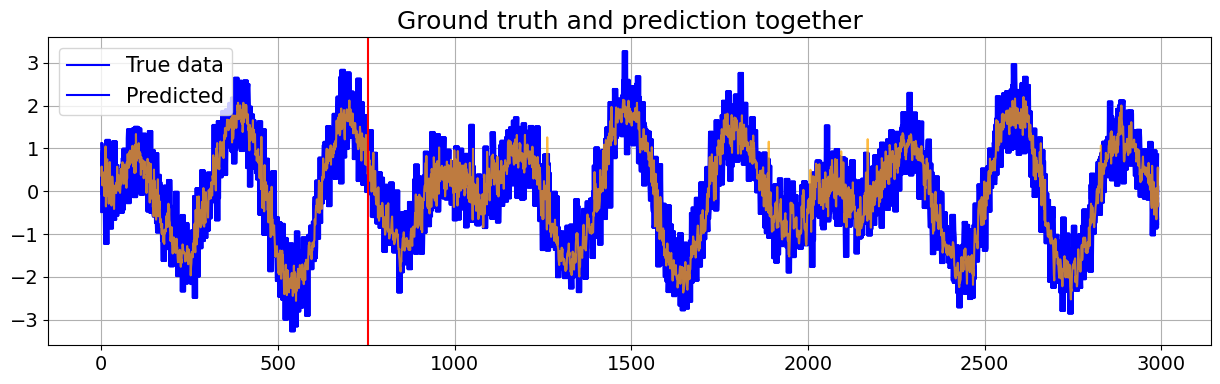

In [39]:
for s in [2,4,6,8,10,12]:
    trainX,testX,trainY,testY,df2 = prepare_data(s)
    model = rnn_simple(num_units=32,num_dense=8,embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Número de épocas

Probemos ahora con una ventana grande (8), y unas cuantas epochs mas.

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran for 100 epochs
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
MAE: 0.423363773207365
----------------------------------------------------------------------------------------------------


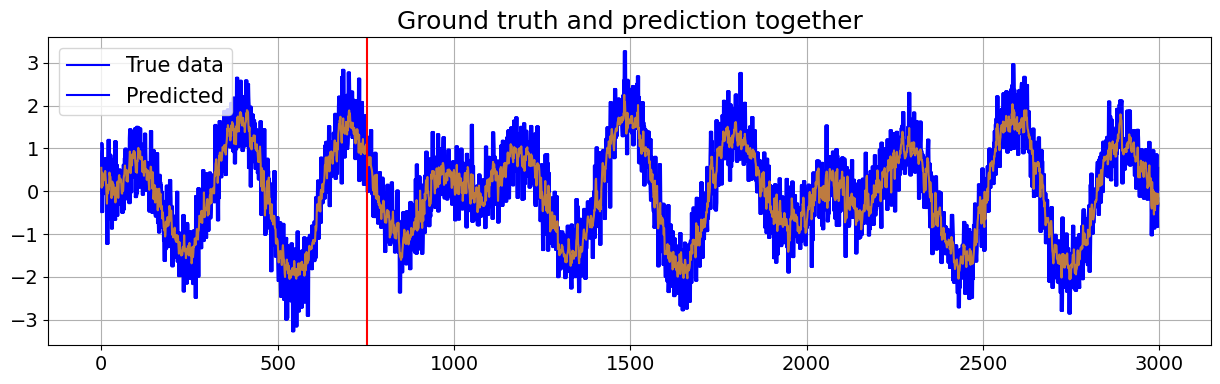

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Ran for 200 epochs
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
MAE: 0.43710226181384976
----------------------------------------------------------------------------------------------------


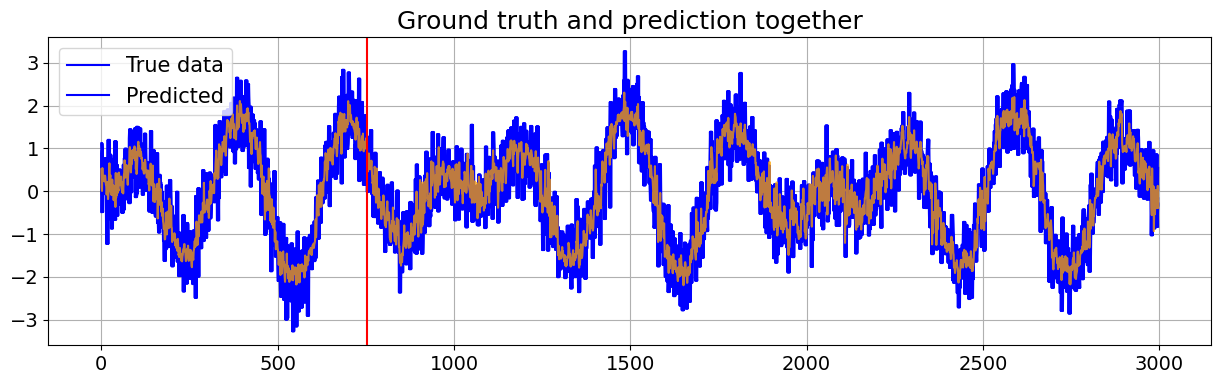

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran for 300 epochs
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
MAE: 0.44441642197014164
----------------------------------------------------------------------------------------------------


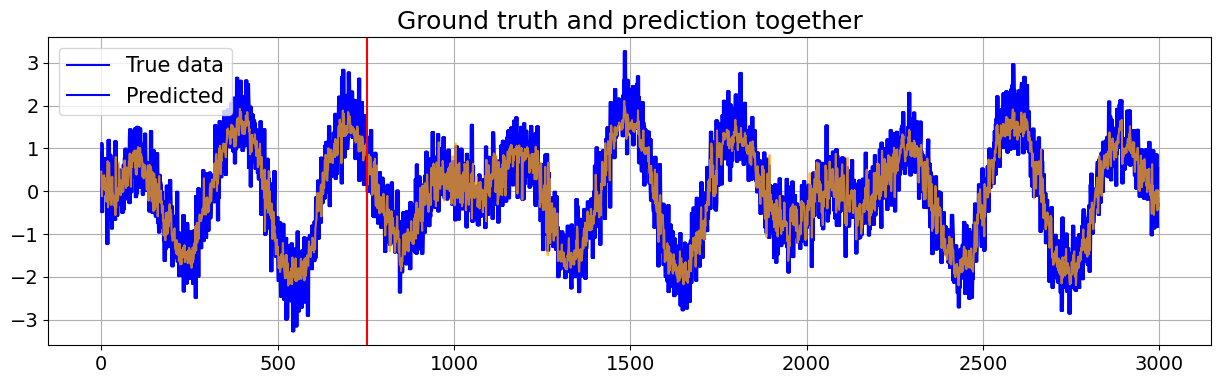

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran for 400 epochs
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
MAE: 0.46298473557176073
----------------------------------------------------------------------------------------------------


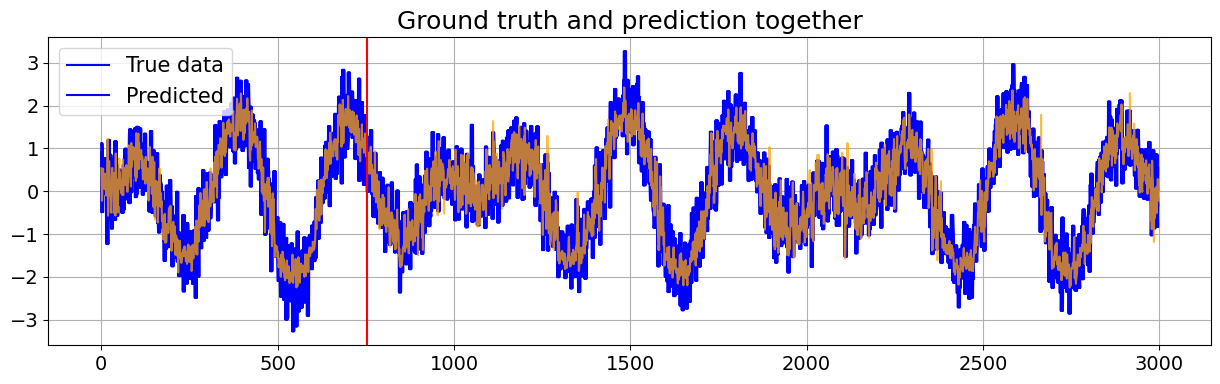

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran for 500 epochs
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
MAE: 0.47866735662564236
----------------------------------------------------------------------------------------------------


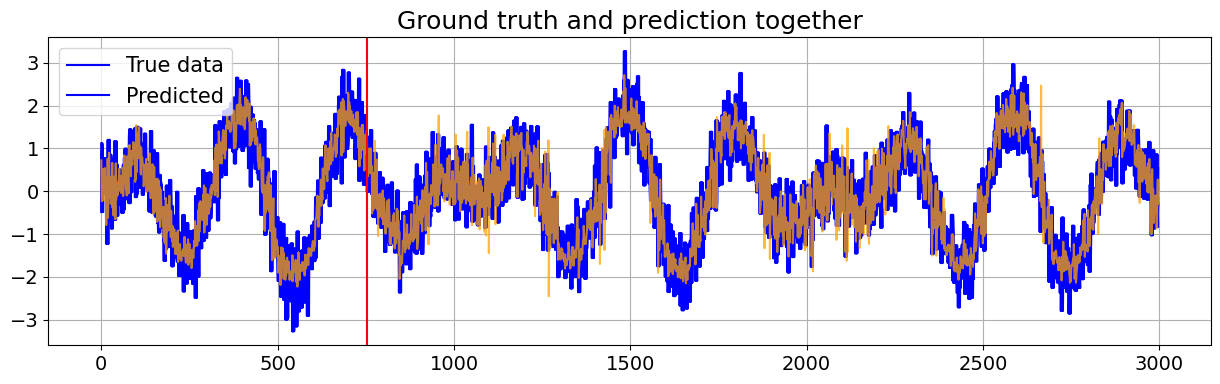

In [40]:
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY, df2 = prepare_data(6)
    model = rnn_simple(num_units=32,num_dense=8,embedding=6)
    batch_size=16
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=e, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Batch size

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran with batch size: 4
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
MAE: 0.4786362216382234
----------------------------------------------------------------------------------------------------


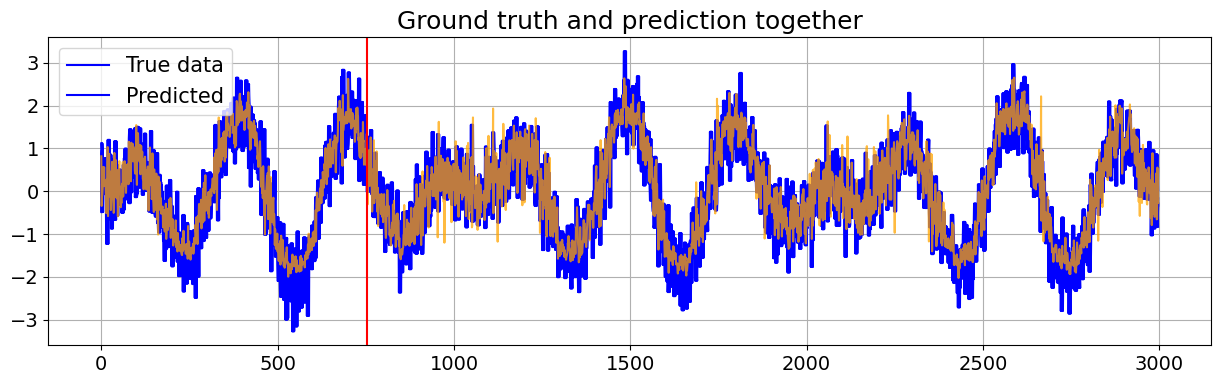

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran with batch size: 8
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
MAE: 0.44084223224211644
----------------------------------------------------------------------------------------------------


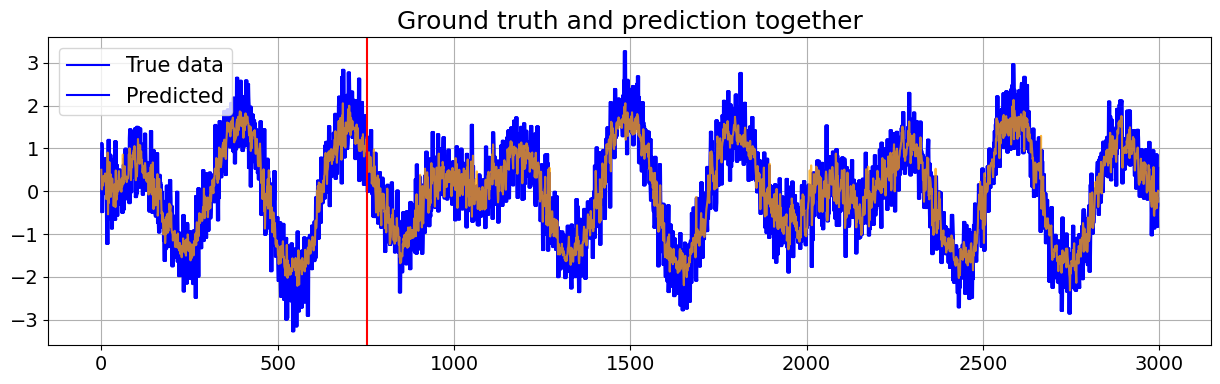

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran with batch size: 16
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
MAE: 0.4428187871001345
----------------------------------------------------------------------------------------------------


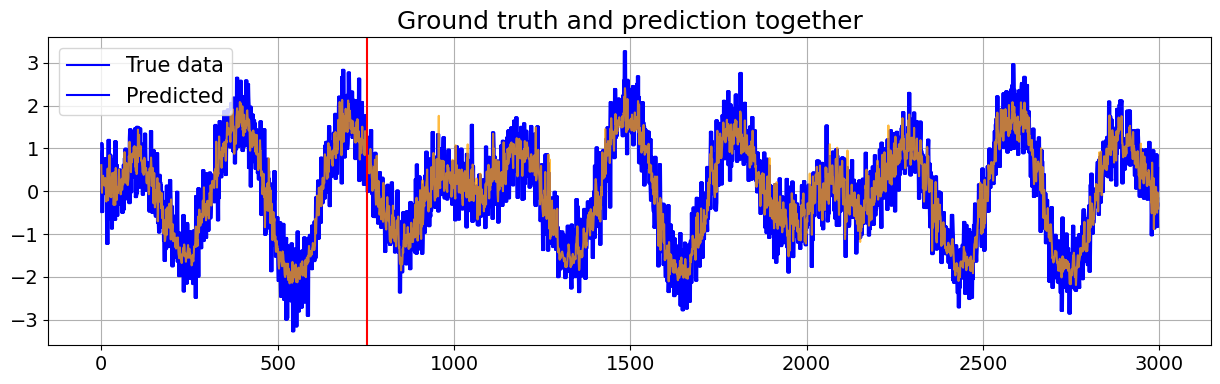

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran with batch size: 32
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
MAE: 0.4339901779297663
----------------------------------------------------------------------------------------------------


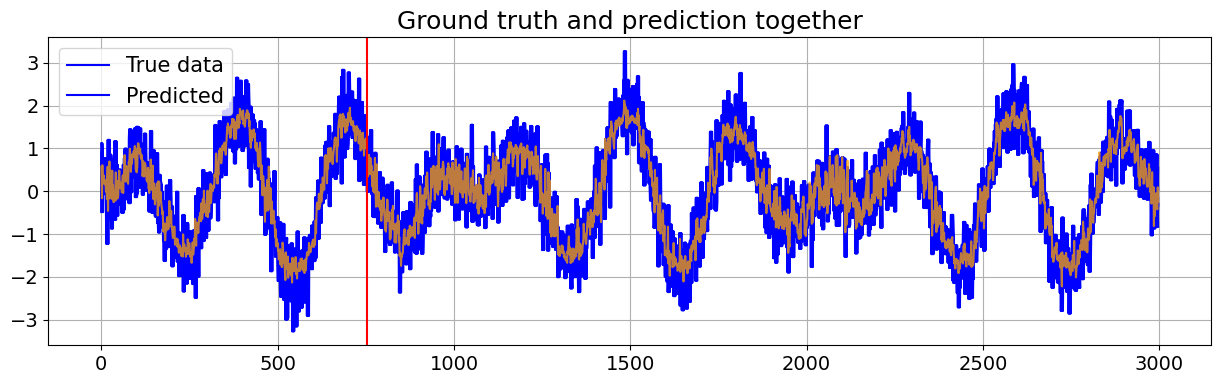

/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-23 16:11:45.146242: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_38', 16 bytes spill stores, 16 bytes spill loads

2024-07-23 16:11:45.618522: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_38', 16 bytes spill stores, 16 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ran with batch size: 64
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
MAE: 0.42814336005947473
----------------------------------------------------------------------------------------------------


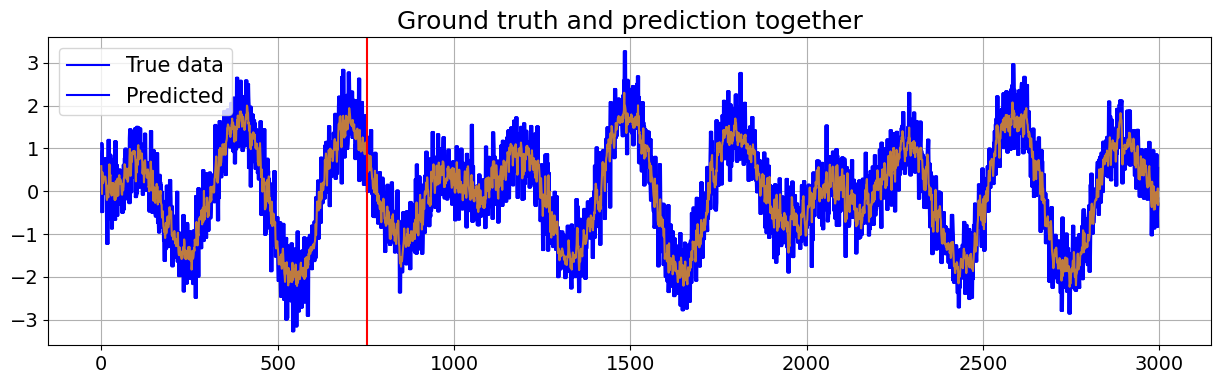

In [41]:
for b in [4,8,16,32,64]:
    trainX,testX,trainY,testY, df2 = prepare_data(6)
    model = rnn_simple(num_units=32,num_dense=8,embedding=6)
    batch_size=b
    num_epochs = 250
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=b,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Resumen

Claramente, se observaron las siguientes tendencias,

- Un tamaño de incrustación demasiado pequeño no es útil, pero una incrustación muy larga tampoco es eficaz. Una incrustación de 8 parece buena para estos datos.
- Un mayor número de épocas no siempre es mejor. Probablemente estamos sufriendo sobreajuste
- Un tamaño de lote de 32 o 64 parece óptimo.

En última instancia, es necesario un ajuste exhaustivo de los hiperparámetros para obtener el mejor rendimiento global.

Referencias:
* LSTM https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/